# Set Up For Link Margin

In [64]:
# Import relevant libraries and such 
import sys
import os
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, CubicSpline
# import propagation_lib as prop 

%matplotlib notebook

## Constants ##
ft2m = 0.3048
c_speed = 3.0e8
kB = 1.39e-23

# Standard Link Margin Calculator

In [65]:
## Set transmitter parameters -- static portrait of what is happening along the trajectory

ht_rocket=500.0 # height of rocket (in km)
freq = 162.990625e6 # transmit frequency (Hz)
txPwr = 2 # transmit power (in Watts)
Gtx = 2.1 # dBi (1992 ARRL Handbook p.17-18 value for half-wave dipole antenna)
txAng = 45 # misalignment between tx and rx antennas

## Set receiver parameters

# Grx = 2.1 # Rx antenna gain, assumed same as Gtx in an isotropic setting 
Grx = 6.09 # Rx antenna gain, when we introduce the two-element yagi (6.09 dBi = maximum gain)
rxAng = 45 # misalignment between tx and rx antennas
# Bn = 200e3 # Receiver [Noise] Bandwidth (Hz) [used min IF bandwidth specified in RSPduo Datasheet]
Bn = 20.0e3 # Receiver Bandwidth expected given testing at Wallops 

# Receiver Noise Figure
# NFrx_dB = 3.3 # in dB given in RSPduo Datasheet for 100/200MHz operation
NFrx_dB = 0.5 # in dB with a pre-amp
NFrx = 10.0**(NFrx_dB/10) # Convert to dimensionless quantity

## Calculations to find the Recieved Signal (i.e., carrier) Power
# Line-of-sight path length from tx to rx in meters
Rrocket = ht_rocket*1.0e3; Rrocket_mod=None
# # [Opt.] Modify Line-of-sight path length to account for misalignment between tx and rx antennas
# Rrocket_mod = Rrocket/(np.cos(45.*np.pi/180.)*np.cos(45.*np.pi/180.)) 
# Set R to use in path loss calculation 
if Rrocket_mod is None: R=Rrocket
else: R=Rrocket_mod
Lpath = (4.*np.pi*R*freq/c_speed)**2 # Path Loss
Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)

## Calculations to find the Carrier-to-Noise Ratio
# Calculate Noise temperature of reciever (asssuming reference temperature of 290K) [See Sat Comm book p. 111]
Tn = 290*(NFrx-1) 
# Calculate the Carrier-to-Noise Ratio
CNR = Pwr_rx/(kB*Bn*Tn)

print('Frequency = %s MHz; Noise Bandwidth = %s kHz' % (freq/1e6, Bn/1e3))
print('EIRP ~= %.2f W (%.2f dBW)' % (txPwr*10.0**(Gtx/10.), 10*np.log10(txPwr*10.0**(Gtx/10.))))
print('RX (Antenna) Gain ~= %.2f (%.2f dB)\n' % (10.0**(Grx/10), Grx))
print('Antenna Angle Misalignments: TX=%s deg, RX=%s deg' % (txAng, rxAng))
print('Distance of RX from TX: %s km\n' % (int(np.round(R/1e3, decimals=0))))
print('Modified EIRP  ~= %.2f W (%.2f dBW)' % (txPwr*10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2, 10*np.log10(txPwr)+Gtx+20.*np.log10(np.cos(txAng*np.pi/180.))))
print('Modified RX Gain ~= %.2f (%.2f dB)' % (10.0**(Grx/10)*np.cos(rxAng*np.pi/180.)**2, Grx+20*np.log10(np.cos(rxAng*np.pi/180.))))
print('Path Loss ~= %s (%.2f dB)\n' % (np.format_float_scientific(Lpath, precision=2), 10*np.log10(Lpath)))
print('Received Signal Power ~= %s W (%.2f dBW)' % (np.format_float_scientific(Pwr_rx, precision=2), 10*np.log10(Pwr_rx)))
print('Receiver Thermal Noise (pre-Amp) ~= %s W (%.2f dBW)' %(np.format_float_scientific(kB*Bn*Tn, precision=2), 10*np.log10(kB*Bn*Tn)))
print("C/N ~= %.2f (%.2f dB)" % (CNR, 10*np.log10(CNR)))

Frequency = 162.990625 MHz; Noise Bandwidth = 20.0 kHz
EIRP ~= 3.24 W (5.11 dBW)
RX (Antenna) Gain ~= 4.06 (6.09 dB)

Antenna Angle Misalignments: TX=45 deg, RX=45 deg
Distance of RX from TX: 500 km

Modified EIRP  ~= 1.62 W (2.10 dBW)
Modified RX Gain ~= 2.03 (3.08 dB)
Path Loss ~= 1.17e+13 (130.66 dB)

Received Signal Power ~= 2.83e-13 W (-125.48 dBW)
Receiver Thermal Noise (pre-Amp) ~= 9.84e-18 W (-170.07 dBW)
C/N ~= 28751.41 (44.59 dB)


# SIMPLE Link Margin Variations -- according to angle/distance/etc

In [51]:
## SIMPLY CHANGING ROCKET'S HEIGHT ALONG TRAJECTORY
    # This assumes a constant 90 degree rx/tx offset -- which is unrealistic but we're just examining parameter space here 

# Create array of altitude from ground to 500 km 
ht_array = []
for n in range(1, 500, 1):
    ht_array.append(n)
rxAng = 45
txAng = 45
received_array = [] # received power along the trajectory

for x in ht_array:
    ht_rocket = x
    Rrocket = ht_rocket*1.0e3
    if Rrocket_mod is None: R=Rrocket
    
    # Calculate Path Loss + Received Power: 
    Lpath = (4.*np.pi*R*freq/c_speed)
    Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)
    received_array.append(10*np.log10(Pwr_rx))

<IPython.core.display.Javascript object>


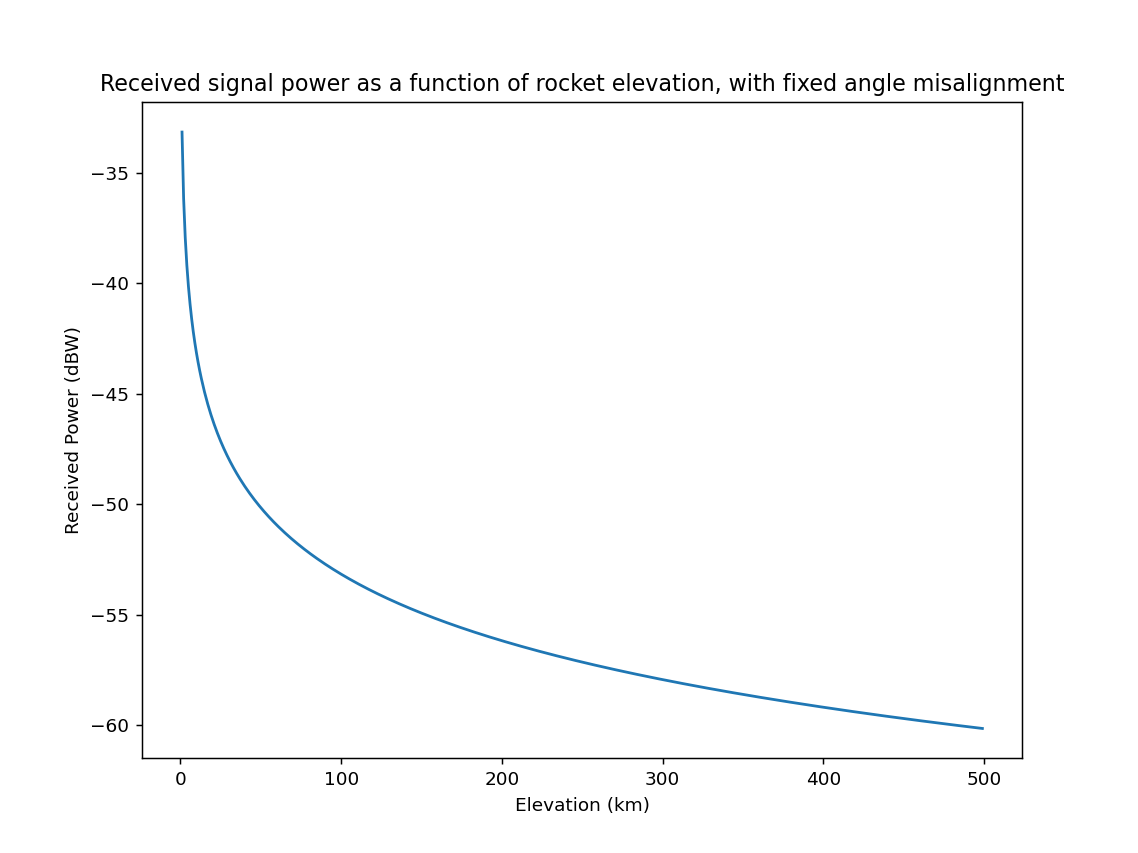

In [52]:
# Plotting above cell 
plt.close()
plt.plot(ht_array, received_array)
plt.title("Received signal power as a function of rocket elevation, with fixed angle misalignment")
plt.xlabel("Elevation (km)")
plt.ylabel("Received Power (dBW)")
plt.show()

In [56]:
## SIMPLY CHANGING ROCKET'S HEIGHT ALONG TRAJECTORY (SAME IDEA as above -- the difference is using array of power inputs)

power_array = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2.0]
ht_array = []
for n in range(1, 500, 1):
    ht_array.append(n)
    
rxAng = 45
txAng = 45

received_array = []
# received power along the trajectory, if angle misalignment remained at 45/45 (i.e. 90)
for level_pwr in power_array:
    received_array_element = []
    for x in ht_array:
        ht_rocket = x
        txPwr = level_pwr
        Rrocket = ht_rocket*1.0e3
        if Rrocket_mod is None: R=Rrocket
        Lpath = (4.*np.pi*R*freq/c_speed)
        Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)
        #print(Pwr_rx)
        received_array_element.append(10*np.log10(Pwr_rx))
    received_array.append(received_array_element)

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'gray']

<IPython.core.display.Javascript object>


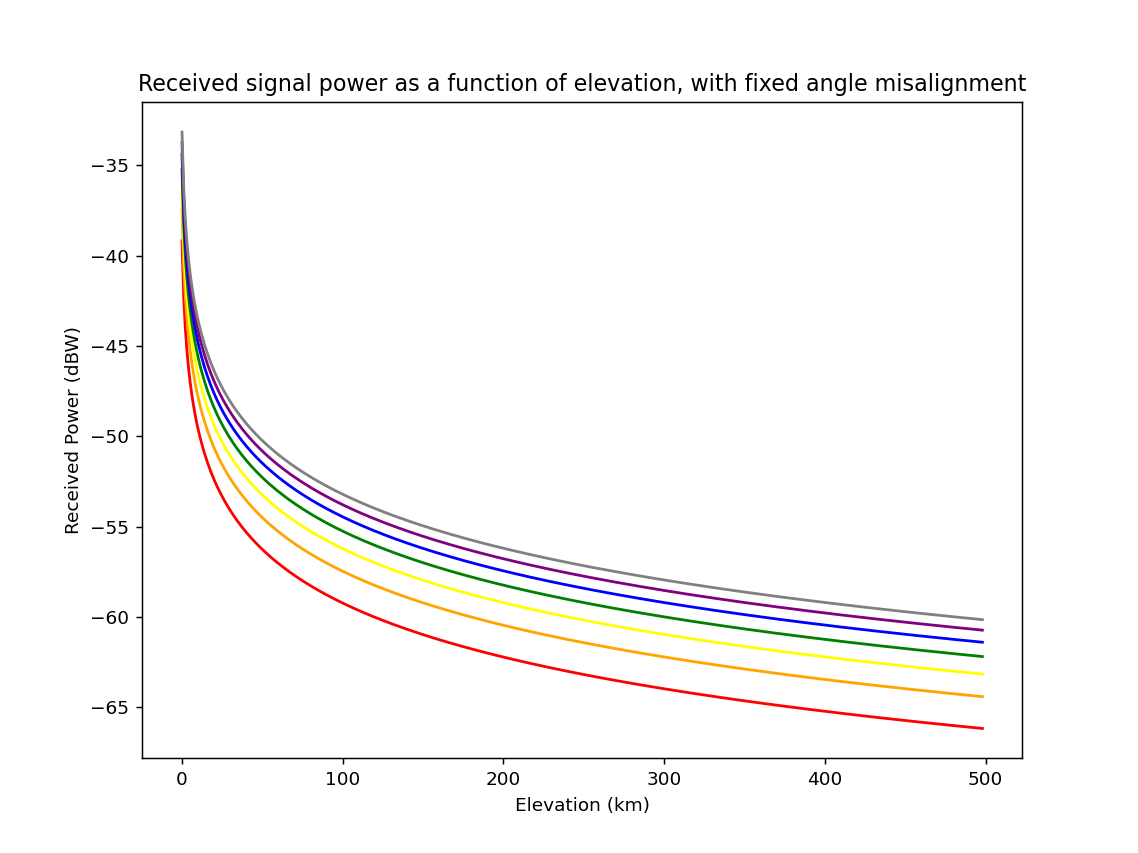

In [57]:
plt.close()
for index, series in enumerate(received_array):
    plt.plot(series, color=colors[index % len(colors)], label=f'Series {index + 1}')
plt.title("Received signal power as a function of elevation, with fixed angle misalignment")
plt.xlabel("Elevation (km)")
plt.ylabel("Received Power (dBW)")
plt.show()

In [60]:
## Same idea as examining the effects of changing height along the trajectory -- look at the misalignment between rx and tx antennas and examine dependence 

## resetting height parameters to top of the trajectory
ht_rocket=500.0
Rrocket = ht_rocket*1.0e3
if Rrocket_mod is None: R=Rrocket  
Lpath = (4.*np.pi*R*freq/c_speed)

# Changing RX angle misalignmnent
angle_array = []
for n in range(0,90,1):
    angle_array.append(n)

received_array = []

for level_pwr in power_array:
    received_array_element = []
    for x in angle_array:
        rxAng = x
        txPwr = level_pwr
        Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)
        #print(Pwr_rx)
        received_array_element.append(10*np.log10(Pwr_rx))
    received_array.append(received_array_element)

<IPython.core.display.Javascript object>


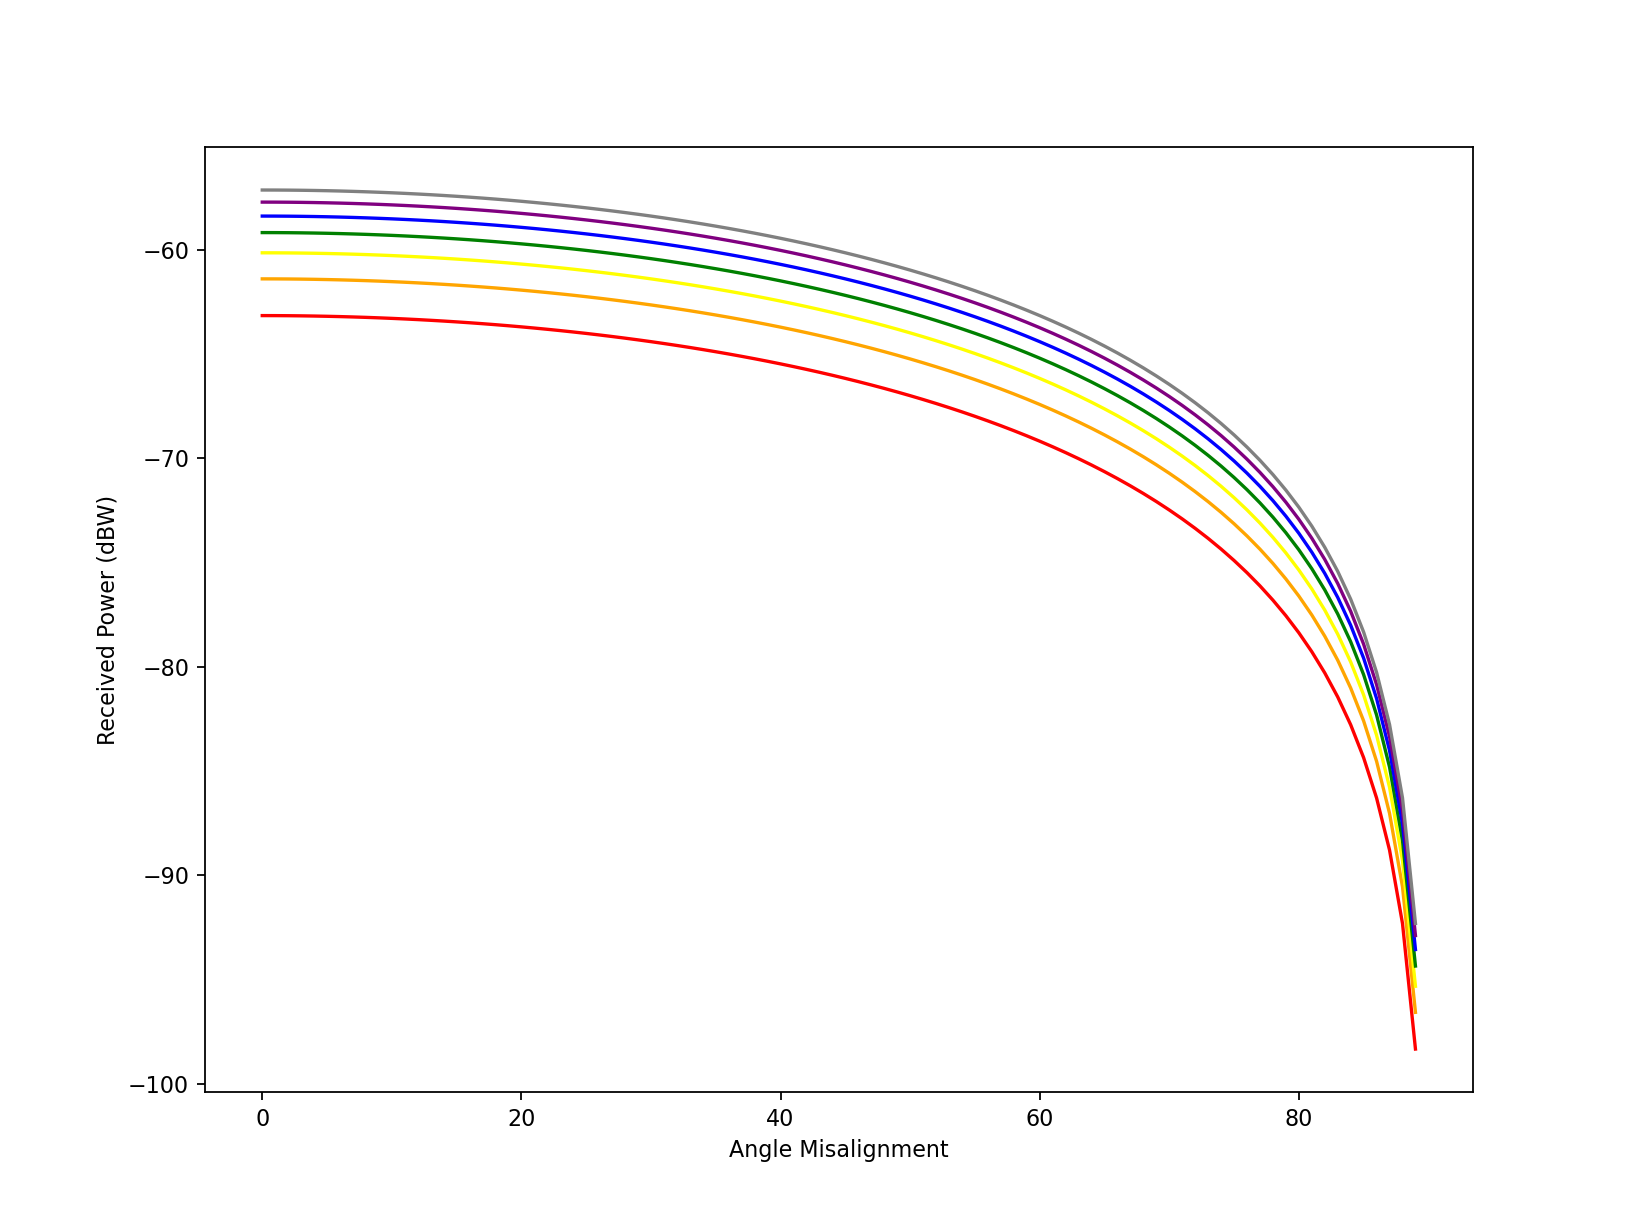

Text(0, 0.5, 'Received Power (dBW)')

In [81]:
plt.close()
for index, series in enumerate(received_array):
    plt.plot(series, color=colors[index % len(colors)], label=f'Series {index + 1}')
plt.xlabel("Angle Misalignment")
plt.ylabel("Received Power (dBW)")

# Loading Trajectory + Receiving Site Information

In [63]:
# Trajectory path 
# Use genfromtxt to load the file with handling for missing values
trajectory = np.genfromtxt("Traj_Right.txt", skip_header=1, dtype=float)

# Read the header separately
with open('Traj_Right.txt', 'r') as file:
    headers = file.readline().strip().split()

# Create arrays for each column using the header titles
traj_arrays = {header: trajectory[:, i] for i, header in enumerate(headers)}

for title, array in traj_arrays.items():
    title = title + "_rttraj"
#     print(f"{title}: {array}")
# print(traj_arrays)

In [ ]:
# PF == poker flat
lat_pf = 65.1192
long_pf = -147.43


In [9]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points 
    on the Earth specified in decimal degrees of latitude and longitude.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula to calculate the distance
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of Earth in kilometers (mean radius)
    R = 6371.0

    # Calculate the distance
    distance = R * c
    return distance

def calculate_distance_and_azimuth(lat_ground, lon_ground, lat_air, lon_air, altitude):
    """
    Calculate the 3D distance and azimuthal angle between a ground point and an aerial point.
    """
    # Calculate horizontal (ground) distance using the Haversine formula
    horizontal_distance = haversine_distance(lat_ground, lon_ground, lat_air, lon_air)
    
    # Convert horizontal distance from kilometers to meters
    horizontal_distance_m = horizontal_distance * 1000

    # Calculate 3D distance using the Pythagorean theorem
    vertical_distance_m = altitude  # in meters
    distance_3d = np.sqrt(horizontal_distance_m**2 + vertical_distance_m**2)
    
    # Calculate the azimuthal angle
    dlon = np.radians(lon_air - lon_ground)
    x = np.sin(dlon) * np.cos(np.radians(lat_air))
    y = (np.cos(np.radians(lat_ground)) * np.sin(np.radians(lat_air)) -
         np.sin(np.radians(lat_ground)) * np.cos(np.radians(lat_air)) * np.cos(dlon))
    
    azimuth = np.degrees(np.arctan2(x, y))
    azimuth = (azimuth + 360) % 360  # Normalize the angle to be between 0 and 360

    return distance_3d, azimuth

# Example coordinates
lat_ground = 34.0522  # Ground latitude
lon_ground = -118.2437  # Ground longitude
lat_air = 34.0500  # Air latitude
lon_air = -118.2500  # Air longitude
altitude = 1000  # Altitude of the air point in meters

# Calculate distance and azimuthal angle
distance, azimuth = calculate_distance_and_azimuth(lat_ground, lon_ground, lat_air, lon_air, altitude)

# Print results
print(f"3D Distance: {distance:.2f} meters")
print(f"Azimuthal Angle: {azimuth:.2f} degrees")

lengths = []
azs = []

for i, time in enumerate(traj_arrays["Time"]):
    latitude = traj_arrays["Latgd"][i]
    longitude = traj_arrays["Long"][i]
    altitude = traj_arrays["Altkm"][i]*1000
#     print(f"Time: {time} sec - Latitude: {latitude} - Longitude: {longitude} - Altitude: {altitude}")
    l, az = calculate_distance_and_azimuth(lat_pf, long_pf, latitude, longitude, altitude)
    lengths.append(l)
    azs.append(az)

print(lengths)
print(azs)

3D Distance: 1181.83 meters
Azimuthal Angle: 247.15 degrees
[2781.4196577502094, 2781.4196577502094, 2781.4946184595237, 2781.569936657946, 2782.2107824916097, 2782.022616446385, 2782.8240759801306, 2782.8240759801306, 2782.8240759801306, 2783.2133855776246, 2784.1085998385042, 2784.678974928702, 2784.678974928702, 2785.4357295192235, 2786.1262220742956, 2787.510838255488, 2789.0215764581953, 2790.2524756997673, 2791.2501784929477, 2791.2501784929477, 2791.944423339284, 2793.975515734799, 2795.989631290059, 2798.3815452208473, 2800.8560376136065, 2803.6711345447193, 2807.089562163952, 2809.9848122199514, 2814.0712978760157, 2818.0462226989885, 2822.8461758793424, 2827.4877046097, 2833.0008724646277, 2838.49888962423, 2845.0175848530685, 2852.099245823437, 2859.670299756636, 2867.757207981294, 2876.8994998100397, 2886.346805876038, 2896.2739199277867, 2907.1005355700618, 2919.518670251656, 2931.8636768346937, 2945.342352447788, 2959.9046939188083, 2974.5781511898776, 2991.323767996927, 

<IPython.core.display.Javascript object>


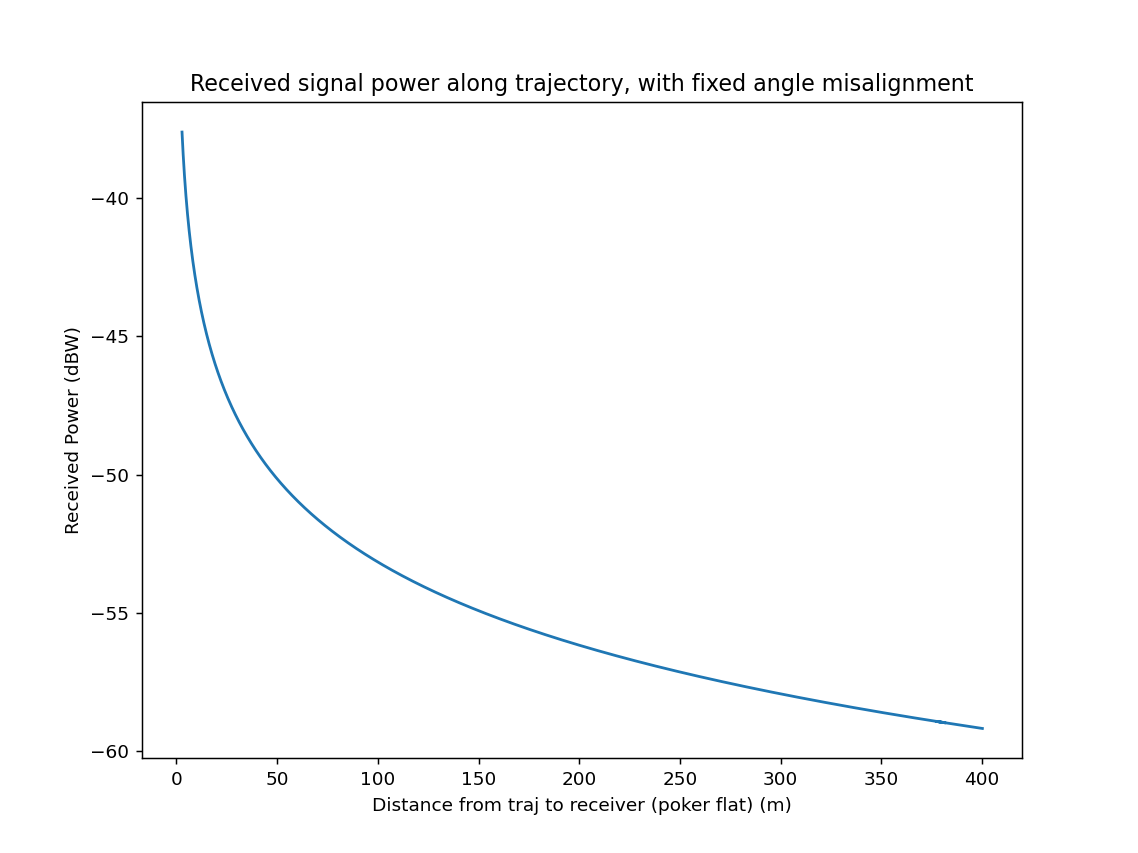

In [10]:
rxAng = 45
txAng = 45
received_array = []
lenx = []
# received power along the trajectory, if angle misalignment remained at 45/45 (i.e. 90)
for x in lengths:
    lenx.append(x/1000)
    ht_rocket = x/1000
    Rrocket = ht_rocket*1.0e3
    if Rrocket_mod is None: R=Rrocket
    Lpath = (4.*np.pi*R*freq/c_speed)
    Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)
    #print(Pwr_rx)
    received_array.append(10*np.log10(Pwr_rx))
    
plt.close()
plt.plot(lenx, received_array)
plt.title("Received signal power along trajectory, with fixed angle misalignment")
plt.xlabel("Distance from traj to receiver (poker flat) (m)")
plt.ylabel("Received Power (dBW)")
plt.show()

<IPython.core.display.Javascript object>


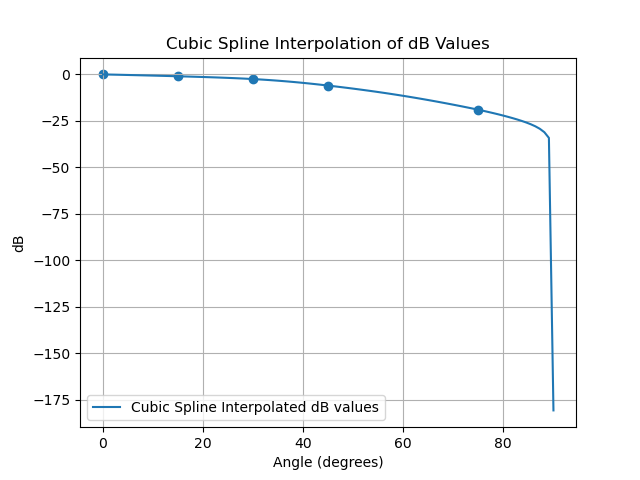

<ipython-input-73-168f0a961b4d>:29: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(angles, 10*np.log10(linear_values))


In [73]:
# modeling two element yagi angular dependence

# Step 1: Define the angles and their corresponding linear values
angles = np.array([0, 15, 30, 45, 75, 90])
linear_values = np.array([10**(0/10), 10**(-1/10), 10**(-2.5/10), 10**(-6/10), 10**(-19/10), 0])

# Step 2: Create the cubic spline interpolation function
# Note: Set 'bc_type' to 'natural' to ensure a more stable interpolation
cubic_spline = CubicSpline(angles, linear_values, bc_type='natural')

# Step 3: Define the new angle range for interpolation
new_angles = np.linspace(0.1, 90, 100)

# Step 4: Interpolate the values using cubic spline
interpolated_linear_values = cubic_spline(new_angles)

# Step 5: Handle small values and convert to dB
# epsilon = 1e-10  # Small value to avoid log(0)
# interpolated_linear_values_safe = np.maximum(interpolated_linear_values, epsilon)
interpolated_db_values = 10 * np.log10(interpolated_linear_values)

# Set interpolated values to -inf where original linear values were zero or negative
# interpolated_db_values[interpolated_linear_values <= 0] = -np.inf

# Step 6: Plotting the results
plt.close()
# plt.plot(angles, 10 * np.log10(linear_values + epsilon), 'o', label='Original dB values')
plt.plot(new_angles, interpolated_db_values, '-', label='Cubic Spline Interpolated dB values')
plt.scatter(angles, 10*np.log10(linear_values))
plt.xlabel('Angle (degrees)')
plt.ylabel('dB')
plt.title('Cubic Spline Interpolation of dB Values')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
# ALONG THE TRAJECTORY az + l dependence of signal received, WITHOUT VARIATION IN GAIN

# FIXED information
freq = 162.990625e6 # transmit frequency (Hz)
txPwr = 2 # transmit power in Watts
Gtx = 2.1 # dBi
Bn = 20e3
NFrx_dB = 0.5 #in dB with a pre-amp
NFrx = 10.0**(NFrx_dB/10) #Convert to dimensionless quantity

receivedpower = []
receivedcn = []

for length, az in zip(lengths, azs):
    ht_rocket = length/1000
    # GAIN of receiver dependent on azimuthal angle!
    Grx = 6.09 + 10*np.log10(cubic_spline(az))
    rxAng = az
    txAng = rxAng
    
    # Line-of-sight path length from tx to rx in meters
    Rrocket = ht_rocket*1.0e3; Rrocket_mod=None
    if Rrocket_mod is None: R=Rrocket
    else: R=Rrocket_mod

    Lpath = (4.*np.pi*R*freq/c_speed)**2 # Path Loss
    Pwr_rx = (txPwr*(10.0**(Gtx/10.)*np.cos(txAng*np.pi/180.)**2)*(10.0**(Grx/10.)*np.cos(rxAng*np.pi/180.)**2))/Lpath # Received Power in Watts at input to receiver (i.e. without LNA gain)

    ## Calculations to find the Carrier-to-Noise Ratio
    # Calculate Noise temperature of reciever (asssuming reference temperature of 290K) [See Sat Comm book p. 111]
    Tn = 290*(NFrx-1) 
    # Calculate the Carrier-to-Noise Ratio
    
    CNR = Pwr_rx/(kB*Bn*Tn)
    receivedpower.append(10*np.log10(Pwr_rx))
    receivedcn.append(CNR)


<ipython-input-83-123e6cee64e9>:17: RuntimeWarning: invalid value encountered in log10
  Grx = 6.09 + 10*np.log10(cubic_spline(az))


<IPython.core.display.Javascript object>


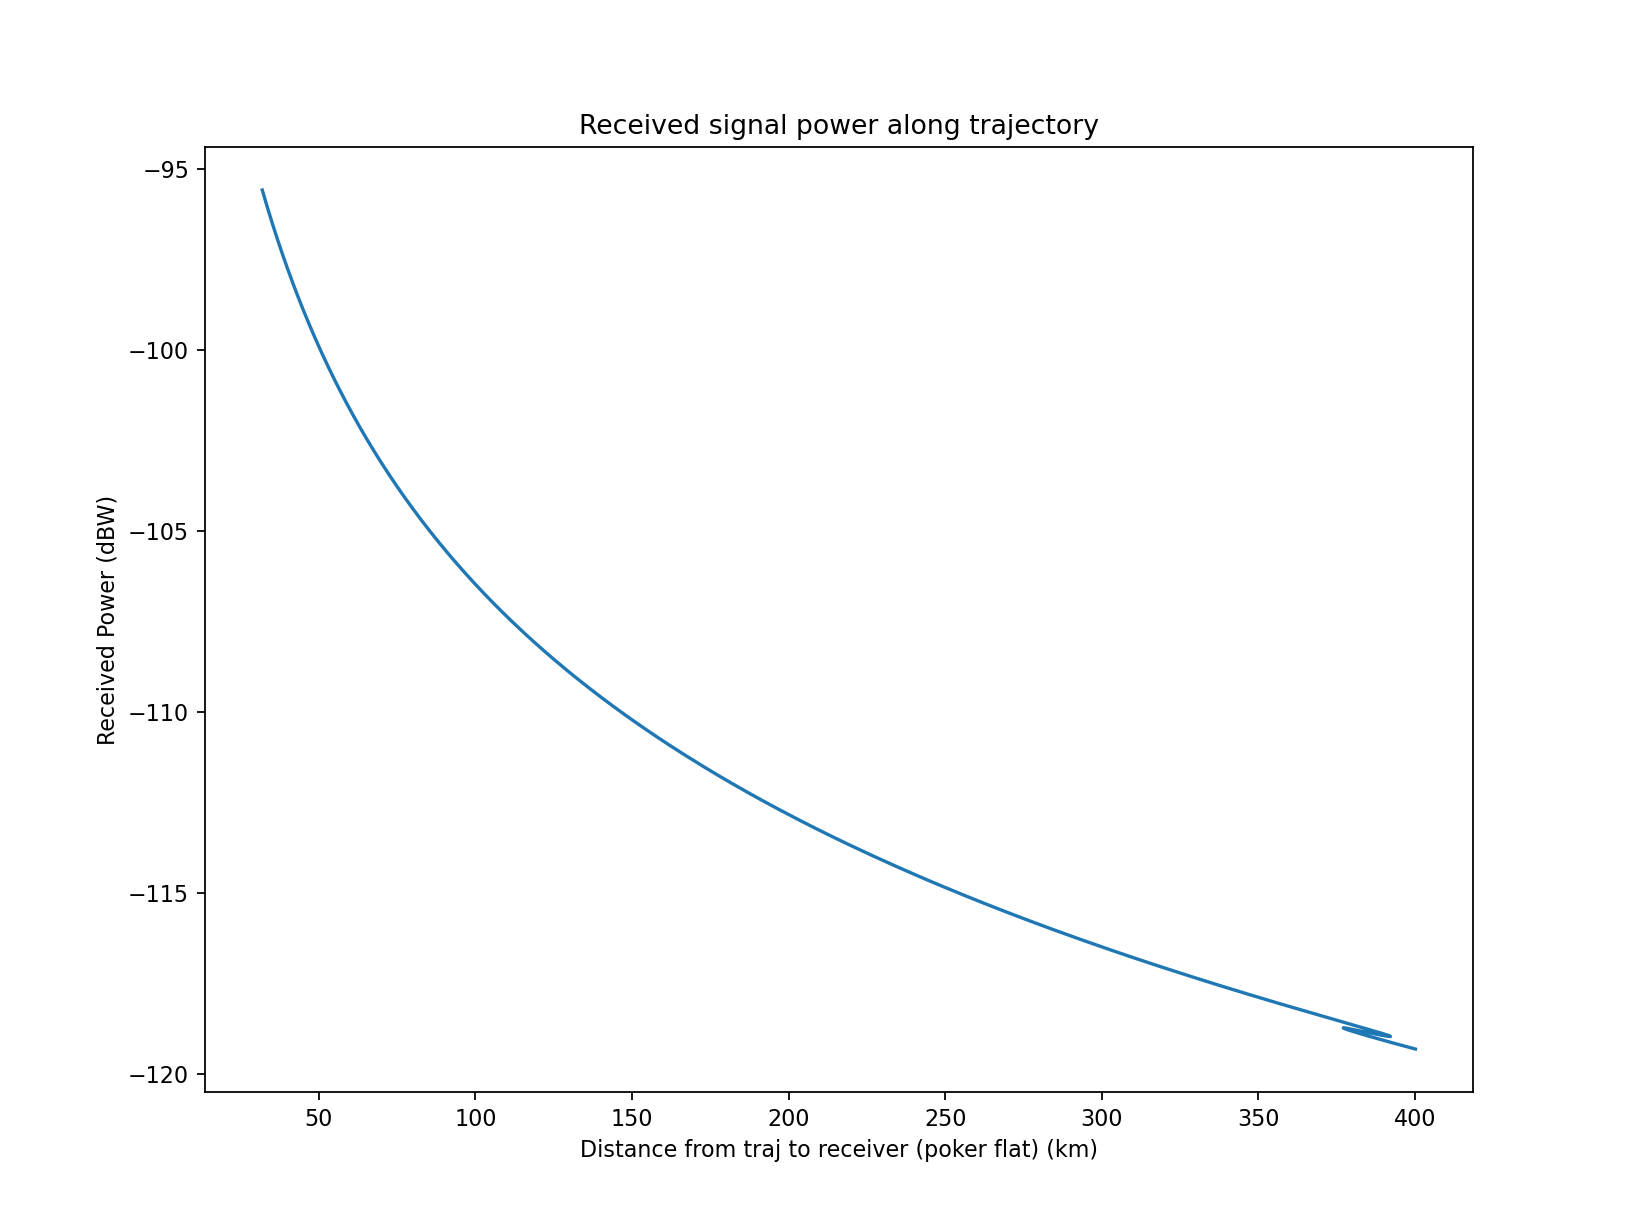

In [84]:
plt.close()
plt.plot(lenx, receivedpower)
plt.title("Received signal power along trajectory")
plt.xlabel("Distance from traj to receiver (poker flat) (km)")
plt.ylabel("Received Power (dBW)")
plt.show()

<IPython.core.display.Javascript object>


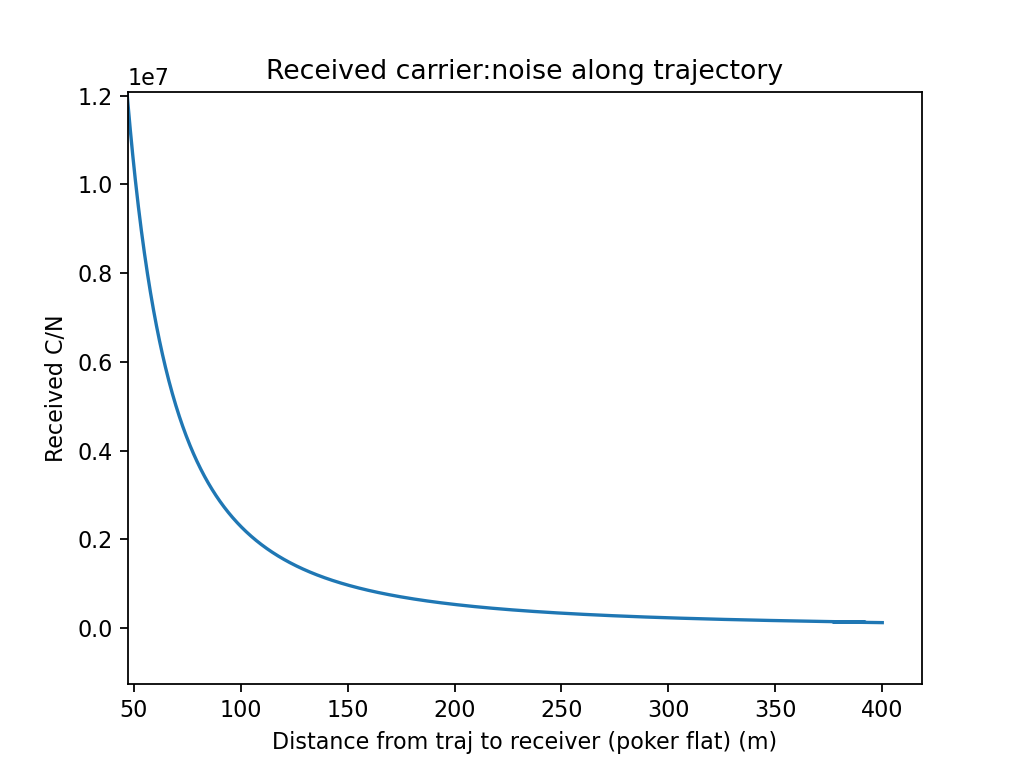

Text(0, 0.5, 'Received C/N')

In [85]:
plt.close()
plt.plot(lenx, receivedcn)
plt.title("Received carrier:noise along trajectory")
plt.xlabel("Distance from traj to receiver (poker flat) (m)")
plt.ylabel("Received C/N")